In [ ]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import scipy as sc
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

ModuleNotFoundError: No module named 'pandas'

## Seizure Preprocessing

### Metadata table

In [37]:
metadata = pd.read_csv('metadata.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)]
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'
len(metadata)
metadata.head()

FileNotFoundError: [Errno 2] No such file or directory: 'metadata.csv'

### Pulling patient metadata

In [2]:
def optimize_localizations(path_to_recon,RID):
    # /mnt/leif/littlab/data/Human_Data/recon/BIDS_penn/
    # python /mnt/leif/littlab/data/Human_Data/recon/code/run_penn_recons.py
    
    atropos_metadata = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
    localization_probs = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
    localization_metadata = pd.read_csv(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.csv')
    def _apply_function(x):
        # look in labels sorted and see if it contains gray matter
        # if gray matter is greater than 5% then set label to gray matter
        x = pd.DataFrame(x).transpose()
        for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
            if (label == 'gray matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 2
                continue
            elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 3
        
        return x

    modified_atropos = atropos_metadata.iloc[:,:].apply(lambda x: _apply_function(x), axis = 1)
    modified_atropos_df = pd.DataFrame(np.squeeze(np.array(modified_atropos.to_list())),columns=atropos_metadata.columns)
    return modified_atropos_df

In [4]:
np.random.seed(42)

with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
pass_path = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))
# Iterate through each patient
for pt in tqdm([pt_list[1]]):
    raw_datapath = ospj(datapath,pt)
    # load dataframe of seizure times
    seizure_times = pd.read_csv(ospj(raw_datapath,f"seizure_times_{pt}.csv"))
    # load electrode information
    if not os.path.exists(ospj(raw_datapath, "electrode_localizations.csv")):
        hup_no = pt[3:]
        rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
        recon_path = ospj('/mnt','leif','littlab','data',
                          'Human_Data','CNT_iEEG_BIDS',
                          f'sub-RID0{rid}','derivatives','ieeg_recon',
                          'module3/')
        if not os.path.exists(recon_path):
            recon_path =  ospj('/mnt','leif','littlab','data',
                          'Human_Data','recon','BIDS_penn',
                          f'sub-RID0{rid}','derivatives','ieeg_recon',
                          'module3/')
        electrode_localizations = optimize_localizations(recon_path,rid)
        electrode_localizations.to_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    else:    
        electrode_localizations = pd.read_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    ch_names = electrode_localizations[(electrode_localizations['index'] == 2) | (electrode_localizations['index'] == 3)]["name"]
    ch_names_clean = clean_labels(ch_names,pt)
    if not os.path.exists(ospj(raw_datapath, "seizures")):
        os.mkdir(ospj(raw_datapath, "seizures"))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


### Pulling and saving seizures

Pipeline:
Pull raw seizure (plus 15 seconds prior to seizure onset)
if not stim:
    Detect bad channels (noisy, nans, zeros)
if lfstim:
    run detect bad channels and manually parse
    use manual stim rejection channels
if hf stim:
    reject stim channel
    Detect bad channels
Store detected bad channels in master dictionary
apply notch filter
apply bandpass filter (1-200)
run artifact detection algorithm
fill in individaul channels/gaps with artifact in them
make master list for channel masking


In [5]:
# Code for within each patient's for loop
for i_sz,row in seizure_times.iterrows():
    if i_sz != 0:
        continue
    if os.path.exists(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl")):
        seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"))
        fs = seizure.pop('fs').to_numpy()[0]
        t = np.arange(0,len(seizure)/fs,1/fs)
        break
    else:
        seizure,fs = get_iEEG_data(usr,pass_path,
                                    row.IEEGname,
                                    row.start*1e6,
                                    row.end*1e6,
                                    ch_names_clean,
                                    force_pull=True)
        t = np.arange(0,len(seizure)/fs,1/fs)
        save_seizure = pd.concat((seizure,pd.DataFrame(np.ones(len(seizure),)*fs,columns=['fs'])),axis = 1)
        save_seizure.to_pickle(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.pkl"),index=False)
        break

AttributeError: 'DataFrame' object has no attribute 'to_pkl'

In [25]:
temp,_ = get_iEEG_data(usr,pass_path,row.IEEGname,(row.start-10)*1e6,row.start*1e6,ch_names_clean,force_pull=True)

In [11]:
plot_iEEG_data(seizure,t)

In [6]:
reject_mask,reject_details = detect_bad_channels(seizure.to_numpy(),fs)
reject_details

{'noisy': [],
 'nans': [],
 'zeros': [],
 'var': [37, 110],
 'higher_std': array([10, 11, 12, 21]),
 'high_voltage': [10, 11, 12]}

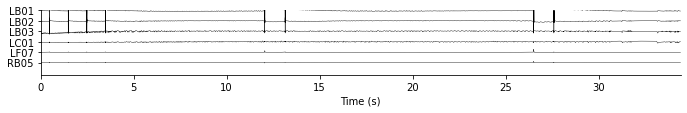

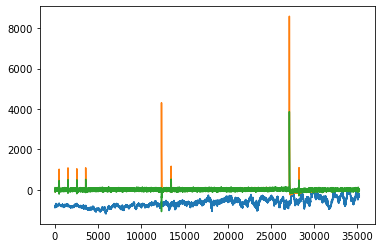

In [18]:
plot_iEEG_data(seizure.iloc[:,~reject_mask],t)
plt.figure()
plt.plot(seizure.iloc[:,[9,37,110]])#reject_details['higher_std']])

### Filtering

In [41]:
# Artifact Removal

x = artifact_removal(seizure.to_numpy(),fs,win_size = .05,
    noise = np.mean(seizure) + 10*np.std(seizure))
# Account for variation
artifact_mask = sig.medfilt(x.any(1).astype(int),5)
stim_idxs = np.reshape(np.where(np.diff(artifact_mask,prepend=0)),(-1,2))
s = seizure.to_numpy().copy()

for i_ch in range(len(ch_names_clean)):
    for win in stim_idxs:
        # Define windows
        win_len = win[1]-win[0]
        pre_idx = win[0] - win_len
        post_idx = win[1] + win_len

        # Interpolation parameters
        pre_idxs = np.arange(pre_idx,win[0])
        post_idxs = np.arange(win[1],post_idx)
        fill_idxs = np.arange(win[0],win[1])

        # Interpolation
        interp_fn = sc.interpolate.interp1d(np.concatenate([t[pre_idxs],t[post_idxs]]),
                                np.concatenate([s[pre_idxs,i_ch],s[post_idxs,i_ch]]))
        filled_s = interp_fn(t[fill_idxs])

        # assigning
        s[win[0]:win[1],i_ch] = filled_s

In [42]:
reject_mask,reject_details = detect_bad_channels(s,fs)
# seizure = pd.DataFrame(s[:,reject_mask],columns=seizure.columns[reject_mask])
reject_details

{'noisy': [],
 'nans': [],
 'zeros': [],
 'var': [],
 'higher_std': array([10, 11, 12, 21]),
 'high_voltage': [10, 12]}

(<Figure size 825.586x28.8 with 1 Axes>, <AxesSubplot:xlabel='Time (s)'>)

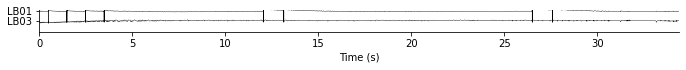

In [43]:
plot_iEEG_data(seizure.iloc[:,reject_details['high_voltage']],t)

In [44]:
notch_seizure = notch_filter(seizure.to_numpy(),fs)
band_seizure = bandpass_filter(notch_seizure,fs)
# car_seizure = band_seizure - np.mean(band_seizure, axis=0)
processed_seizure = pd.DataFrame(band_seizure,columns=seizure.columns)

(<Figure size 825.586x2563.2 with 1 Axes>, <AxesSubplot:xlabel='Time (s)'>)

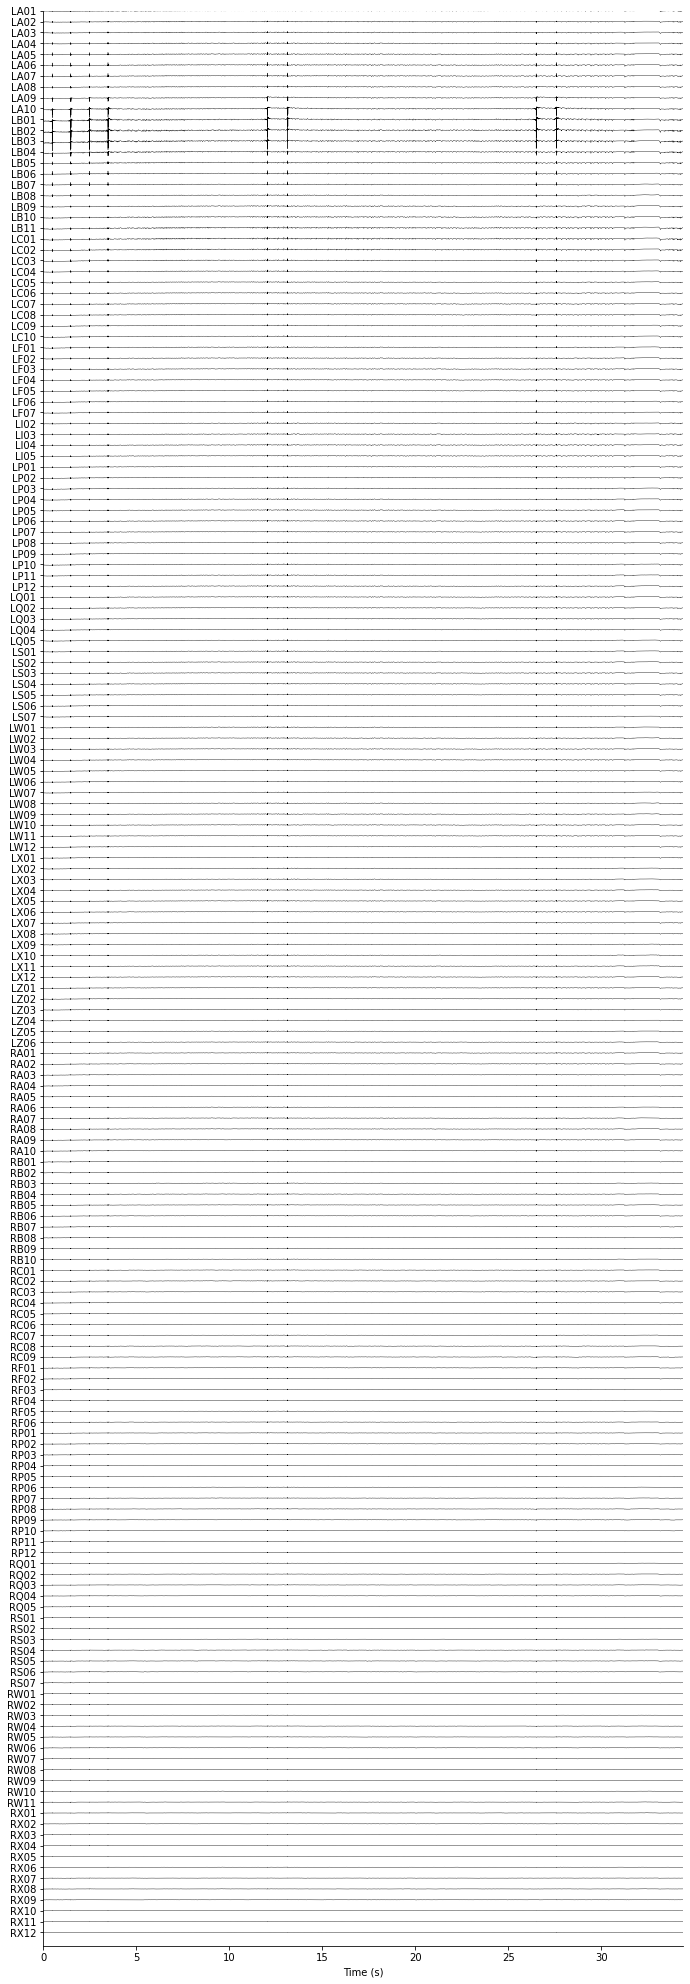

In [45]:
plot_iEEG_data(processed_seizure,t)

### Stim Artifact Removal

In [46]:
def artifact_removal(
    data: np.ndarray, fs: float, discon=1 / 12, noise=15000, win_size=1
) -> np.ndarray:
    """_summary_

    Args:
        data pandas
        fs (float): _description_
        discon (_type_, optional): _description_. Defaults to 1/12.
        noise (int, optional): _description_. Defaults to 15000.
        win_size (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: _description_
    """
    win_size = int(win_size * fs)
    
    n_wins = np.ceil(data.shape[0]/win_size)
    max_inds = n_wins*win_size
     
    all_inds = np.arange(max_inds)
    all_inds[data.shape[0]:] = np.nan
    ind_overlap = np.reshape(all_inds, (-1, int(win_size)))
    
    artifacts = np.empty_like(data)

    # mask indices with nan values
    artifacts = np.isnan(data)

    for win_inds in ind_overlap:
        win_inds = win_inds[~np.isnan(win_inds)].astype(int)
        is_disconnected = np.sum(np.abs(data[win_inds,:]), axis=0) < discon

        is_noise = (
            np.sqrt(np.sum(np.power(np.diff(data[win_inds,:], axis=0), 2), axis=0))
            > noise
        )

        artifacts[win_inds, :] = np.logical_or(
            artifacts[win_inds, :].any(axis=0), np.logical_or(is_disconnected, is_noise)
        )

    return artifacts

In [60]:
art_idxs = artifact_removal(seizure.to_numpy(),fs,win_size = .05,
                 noise = np.abs(np.mean(seizure)) + 10*np.std(seizure))

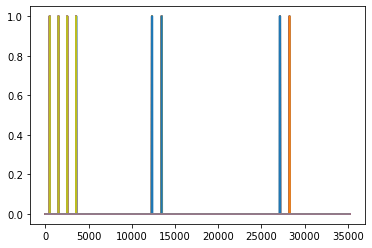

In [61]:
plt.figure();
plt.plot(art_idxs);

In [68]:
artifact_mask = sig.medfilt(art_idxs.astype(int),(3,1))
stim_idxs = [np.reshape(np.where(np.diff(artifact_mask[:,ch],prepend=0)),(-1,2))for ch in range(art_idxs.shape[1])]

In [72]:
np.random.seed(42)
for i_ch in range(sum(reject_mask)):
    for win in stim_idxs[i_ch]:
        win_len = win[1]-win[0]
        pre_idx = win[0] - win_len
        post_idx = win[1] + win_len
        
        # Plotting raw signal
        plot_seg = processed_seizure.iloc[pre_idx:post_idx,i_ch].to_numpy()
        # plt.figure()
        # plt.plot(t[np.arange(pre_idx,post_idx)],plot_seg)
        # plt.vlines([(win_len + pre_idx)/fs, (2*win_len+pre_idx)/fs],plot_seg.min(),plot_seg.max())

        # Interpolation parameters
        s = processed_seizure.to_numpy()
        pre_idxs = np.arange(pre_idx,win[0])
        post_idxs = np.arange(win[1],post_idx)
        fill_idxs = np.arange(win[0],win[1])

        # Interpolation
        interp_fn = sc.interpolate.interp1d(np.concatenate([t[pre_idxs],t[post_idxs]]),
                                np.concatenate([s[pre_idxs,i_ch],s[post_idxs,i_ch]]))
        filled_s = interp_fn(t[fill_idxs])

        # Adding noise to interpolation
        sample_std = np.mean(
            [np.std(s[pre_idxs,i_ch]),np.std(s[post_idxs,i_ch])])
        interp_samples = np.random.normal(filled_s,np.ones_like(filled_s)*sample_std)

        # Plotting interpolation
        # plt.figure()
        # plt.plot(t[pre_idxs],s[pre_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],filled_s,color='r')
        # plt.plot(t[post_idxs],s[post_idxs,i_ch],color='k')
        # plt.plot(t[fill_idxs],sc.ndimage.gaussian_filter1d(interp_samples,2),color='b')
        
        s[win[0]:win[1],i_ch] = interp_samples



In [73]:
cols = ch_names_clean
cols.append('fs')
postrejection_seizure = pd.DataFrame(np.concatenate((s,np.ones((len(s,),1))*fs),axis=1), columns = cols)

ValueError: Shape of passed values is (35226, 179), indices imply (35226, 180)

In [14]:
postrejection_seizure.head()

,LA01,LA02,LA03,LA04,LA05,LA06,LA07,LA08,LA09,LA10,...,RX04,RX05,RX06,RX07,RX08,RX09,RX10,RX11,RX12,fs
0,-11.307630,-82.435640,-183.886656,-321.866059,-473.906294,-596.602208,-631.312579,-519.130868,-249.172990,79.277600,...,63.558859,64.645873,63.280066,59.409195,52.679899,43.741894,33.620877,22.696853,11.111212,1024.0
1,-20.458989,-105.086886,-220.195640,-371.150717,-533.342803,-661.333651,-697.234931,-587.148223,-327.358424,-20.880747,...,62.233698,64.399693,63.873369,60.371918,53.535453,44.082801,33.049040,20.807859,7.623095,1024.0
2,-26.079361,-123.015405,-250.749836,-414.103509,-586.589175,-720.658384,-758.855341,-652.261991,-404.771658,-123.382777,...,41.916384,44.511579,44.586323,41.558770,34.919633,25.714218,15.769212,6.108452,-3.273982,1024.0
3,-39.396995,-148.716435,-288.673849,-463.233195,-644.094379,-782.234849,-821.831966,-720.313941,-489.864140,-240.479386,...,36.999877,39.866003,40.407394,38.154524,32.361221,23.601703,13.330217,2.556351,-8.405933,1024.0
4,-52.820031,-171.732508,-321.668785,-505.718644,-693.339935,-833.900705,-873.975966,-778.918906,-570.482511,-360.944077,...,28.578148,32.487909,33.697387,31.678946,25.802966,16.806609,6.249420,-4.810260,-16.046001,1024.0


(<Figure size 825.586x2563.2 with 1 Axes>, <AxesSubplot:xlabel='Time (s)'>)

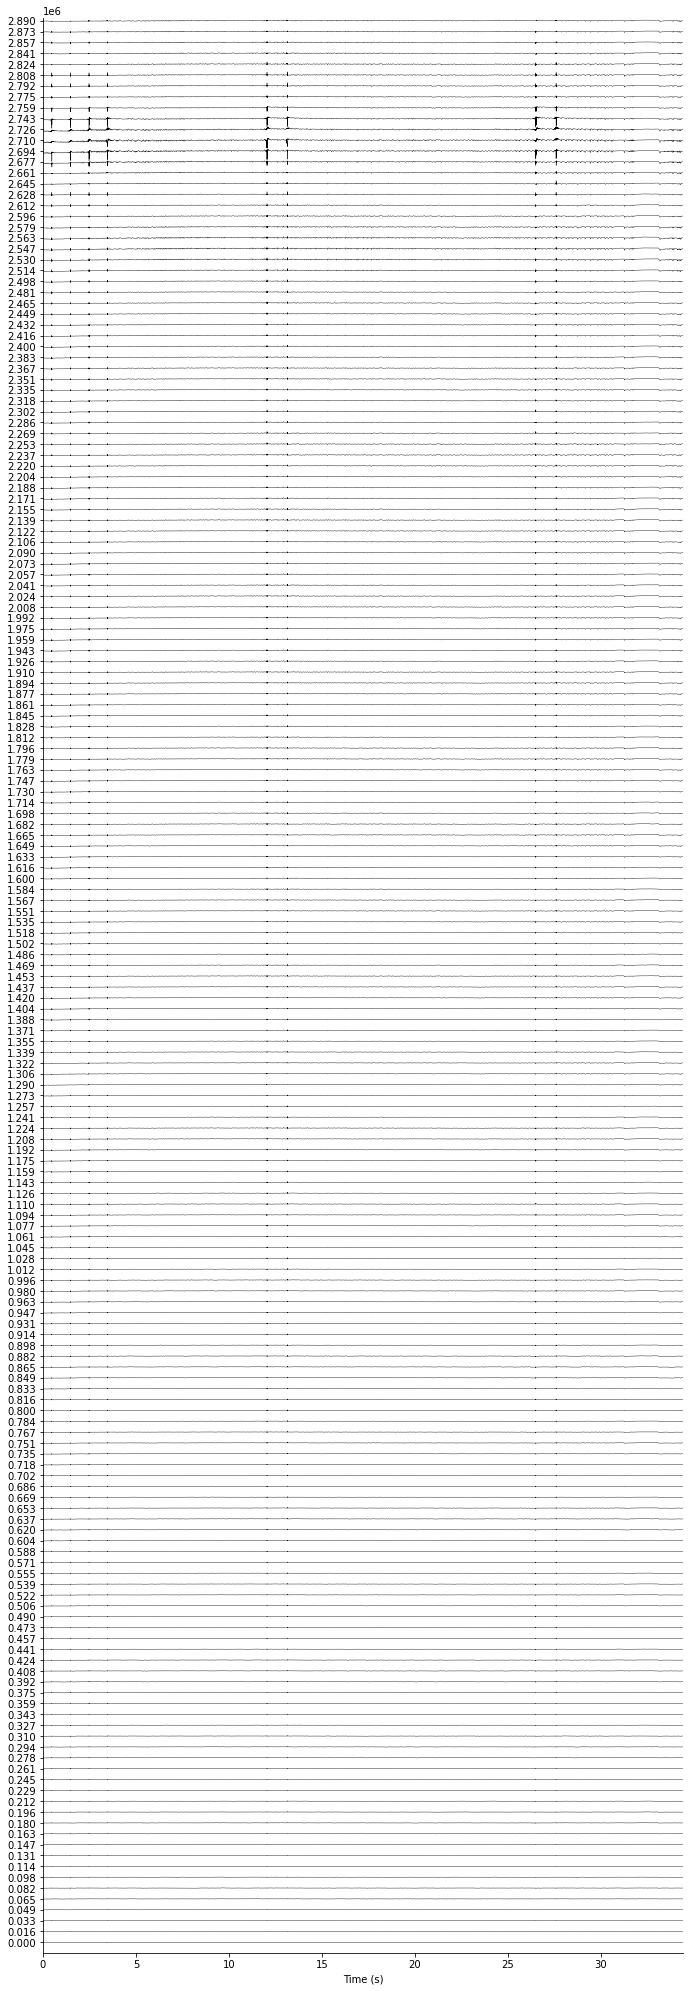

In [74]:
plot_iEEG_data(s,t)